# Import Library

In [ ]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq # untuk menampilkna bar progres saat proses iterasi

In [ ]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Untuk menonaktifkan warinig yang mungkin muncul, seperti FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Loading

## Mengambil Data dari Kaggle

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bustanulkhair","key":"3e36fe8ac6ccada7997213e64e4075a7"}'}

In [ ]:
# Buat direktori jika belum ada

os.makedirs("/root/.kaggle", exist_ok=True)

# Pindahkan file ke direktori .kaggle

shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Atur permission agar tidak terlalu terbuka

os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images
!unzip labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

menggunakan perintah !kaggle datasets download untuk mengunduh dataset dengan nama -d tolgadincer/labeled-chest-xray-images dari Kaggle. Dataset ini disebut "labeled-chest-xray-images" dan dikaitkan dengan pengguna "tolgadincer".

perintah !unzip untuk mengekstrak file zip yang baru saja diunduh. proese ini akan mengekstrak file tersebut dalam foleder yang sama tempat notebook colab berada

## Data Preparation

In [ ]:
import os
import shutil


In [ ]:
# Direktori awal untuk train dan test
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

# Direktori baru untuk dataset gabungan
combined_dir = "chest_xray/dataset"

menentukan direktori awal untuk train dan test, serta direktori baru dalam meyimpan dataset yang telah digabungkan

In [ ]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

## Dataset Checking

membuat kamus yang akan meyimpan daftar gambar untuk setiap kelas dalam dataset


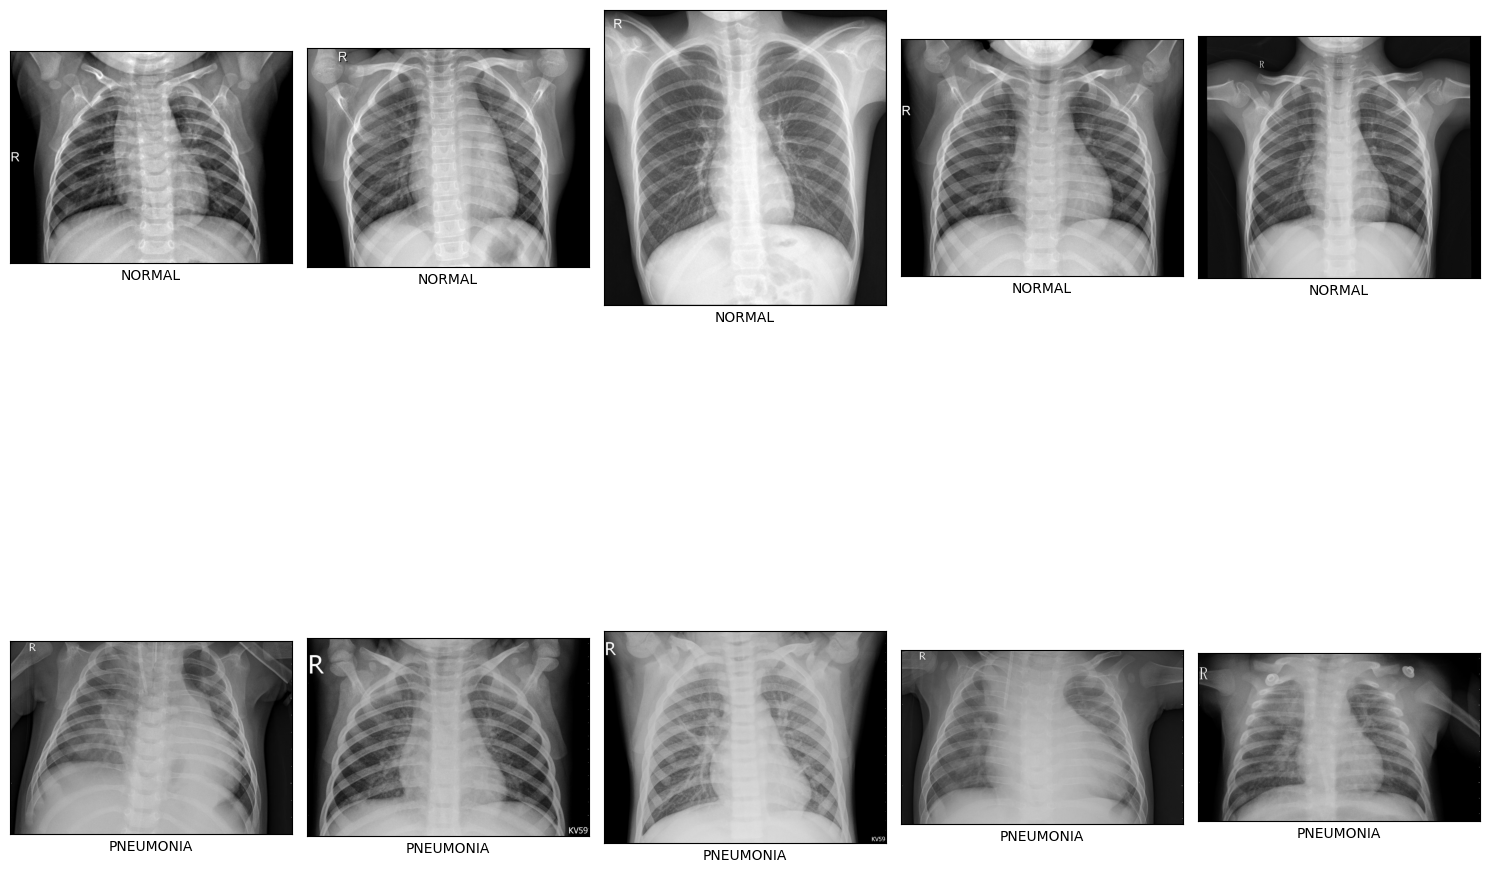

In [ ]:
# Membuat kamus yang meyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path seumber train
path = 'chest_xray/'
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkna secara acak 5 gambar di bawah setiap dari 2 kelas dari data
# anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan
path_sub = "chest_xray/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L") # Konversi menjadi skal keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

kita menampilkan secara acak lima gambar dari masing masing kelas dalam dataset tersebut. ini membantu kita untuk melihat variasi gambar yang ada dalam setiap kelas. proses ini berguna untuk memahami karakteristik serta memastikan bahwa data kita terlihat seimbang antara kelas positif dan negatid. grafik yang dihasilkan akan menampilkan lima gambar setiap kelas dengan nama kelas sebagai labelnya.

## Plot Distribusi

Disini, kita menerapkan path sumber dalam variabel lung_path, yang menunjukkan direktori lokasi dataset berada


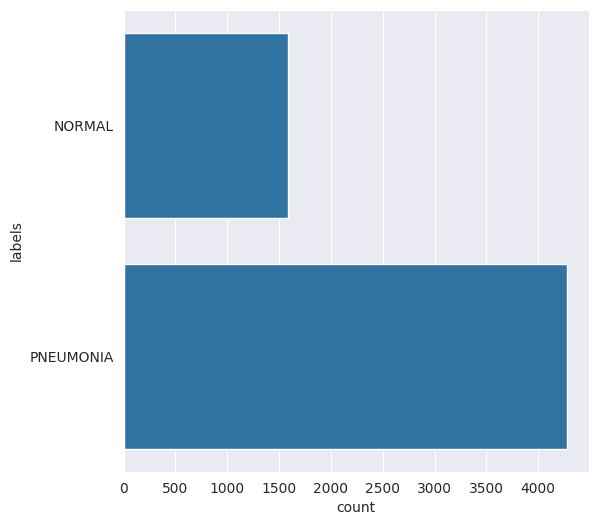

In [ ]:
# Define source path
lung_path = "chest_xray/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

Kemudian, kita membuat tiga list, yaitu file_name, labels, dan full_path. List file_name akan menyimpan nama file gambar, labels akan menyimpan label dari kelas yang sesuai dengan gambar, dan full_path akan menyimpan path dari setiap file gambar.

selanjutnya kita menggunakan looping untuk mendapatkan nama file, path file, dan label dari seetiap gambarr dalam dataset. data  tersebut kemudian disimpan dalam dataframe distribution_train

akhirnya, kita membuat plot untuk menampilkan distibusi gambar di setiap kelas. plot ini menujukkan jumlah gambar yang ada di setiap kelas dalam dataset. terlihat bahwa penyebaran data tidak merata antara kedua label. label pneunomia memiliki jumlah yang lebih banyak dibandingkan dengan label normal. kondisi ini  dapat menyebabkan ketidakseimbangan pada pembelajaran model. yaitu model mungkin cenderung lebih baik dalam memprediksi kelas mayoritas daripada kelas minoritas

untuk mengatasi hal ini, tahapan data augmentation diperlukan. kita menghasilkan variasi dari data yang ada untuk kelas minoritas agar jumlahnya setara dengan kelas mayorittas. ini akan membantu model untuk belajar dengan lebih baik dan mengahsilkan prediksi yang lebih seimbang.

# Data Augmentation

berikut adalah beberapa strategi augmentasi yang kita terapkan

- anticlockwise_rotation adalah ketika gambar diputar ke arah berlawanan dengan jaruh jam
- clockwise_rotation adalah ketika gambar diputar searah dengan jarum jam
- flip_up_down adalah ketika gambar dibalik secara vertikal dari atas ke bawah
- shared adalah ketika gambar diberikan efek pergeseran acak
- wrap_shift adalah ketika gambar diberikan efek pergeseran melengkung
- brightness adalah ketika gambar diberikan efek peningkatan kecereahan

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import numpy as np
# import random

# # Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
# def anticlockwise_rotation(img):
#     img = tf.image.resize(img, (224, 224))
#     img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
#     return img

# # Membuat fungsi untuk melakukan rotasi searah jarum jam
# def clockwise_rotation(img):
#     img = tf.image.resize(img, (224, 224))
#     img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
#     return img

# # Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
# def flip_up_down(img):
#     img = tf.image.resize(img, (224, 224))
#     img = tf.image.flip_up_down(img)
#     return img

# # Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
# def add_brightness(img):
#     img = tf.image.resize(img, (224, 224))
#     img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
#     return img

# # Membuat fungsi untuk memberikan efek blur pada gambar
# def blur_image(img):
#     img = tf.image.resize(img, (224, 224))
#     img = tf.image.random_blur(img, (3, 3))  # Ukuran kernel blur bisa disesuaikan
#     return img

# # Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
# def sheared(img):
#     img = tf.image.resize(img, (224, 224))
#     # Buat objek ImageDataGenerator dengan parameter shearing range
#     datagen = ImageDataGenerator(shear_range=0.2)
#     img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
#     return img

# # Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
# def warp_shift(img):
#     img = tf.image.resize(img, (224, 224))
#     # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
#     datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
#     img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
#     return img

selanjutnya augmentasi dilakukan pada gambar gambar niormal dalam dataset. pertama, kita mendefiniskan berbagai transformasi yang akan diterapkan, seperti rotasi, oergeseran, blur, dan lainnya. kemudian, kita membaca nama nama gambar dari folder yang berisi gambar gambar normal.

selanjutnya, kita menghasilkan gambar gambar baru dengan menerapkan transformasi acak pada setiap gambar asli. proses ini dilakukan hingga jumlah gambar mencapai target. hasil dari augmentasi ini akan membantu memperluas dataset dengan variasi lebih banyak, yang tepat digunakan untuk melatih model lebih baik.

In [ ]:
# transformations = {
#     'rotate anticlockwise': anticlockwise_rotation,
#     'rotate clockwise': clockwise_rotation,
#     'warp shift': warp_shift,
#     'blurring image': blur_image,
#     'add brightness': add_brightness,
#     'flip up down': flip_up_down,
#     'shear image': sheared
# }

# images_path = "chest_xray/dataset/NORMAL"  # Path for the original image
# augmented_path = "chest_xray/dataset/NORMAL_augmented"  # Path to put the augmented image
# images = []  # To save images that have been preprocessed from the folder

# # Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
# for im in os.listdir(images_path):
#     images.append(os.path.join(images_path, im))

# # Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
# images_to_generate = 2000
# i = 1

# while i <= images_to_generate:
#     image = random.choice(images)
#     try:
#         original_image = io.imread(image)

#         # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
#         if original_image.ndim not in [3, 4]:
#             raise ValueError('Invalid image dimensions')

#         transformed_image = None
#         n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
#         transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

#         while n <= transformation_count:
#             key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
#             transformed_image = transformations[key](original_image)
#             n = n + 1

#         new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
#         transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
#         cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
#         i = i + 1
#     except ValueError as e:
#         print('Could not read or process the image', image, ':', e, 'hence skipping it.')

selanjutnya adalah visualisasi distribusi gambar gambar pada setiap kelas dalam dataset. pertama, kita mendefinisikan path sumber data. lalu, kita membuat list yang menyimpan nama file, path lengkap, dan label dari setiap gambar dalam dataset. setelah itu, kita membaut dataframe dari ketika list tersebut.

kemudian, kita menggunakan seabor untuk membuat plot countplot yang menunjukkan distribusi jumlah kgambar pada setiap kelas. hal ini membantiu kita memahami sebaran data dalam dataset, seimbangg atu tidak antara kelas kelas yang berbeda.

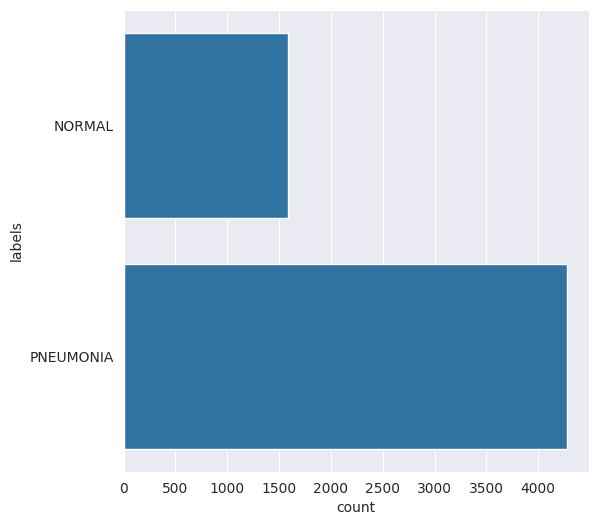

In [ ]:
# # Define source path
# lung_path = "chest_xray/dataset/"

# # Create a list that stores data for each filenames, filepaths, and labels in the data
# file_name = []
# labels = []
# full_path = []

# # Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
# for path, subdirs, files in os.walk(lung_path):
#     for name in files:
#         full_path.append(os.path.join(path, name))
#         labels.append(path.split('/')[-1])
#         file_name.append(name)

# distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# # Plot the distribution of images across the classes
# Label = distribution_train['labels']
# plt.figure(figsize = (6,6))
# sns.set_style("darkgrid")
# plot_data = sns.countplot(Label)

# Data Splitting : Training dan Testing


In [ ]:
mypath = 'chest_xray/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menajdi dataframe agar rapih
df = pd.DataFrame({'path':full_path,'file_name':file_name,'labels':labels})
# melihat jumlah data data gambar pada masing masing label
df.groupby(['labels']).size()

,0
labels,
NORMAL,1583
PNEUMONIA,4273


In [ ]:
# Variabel yang digunakan pada pemisahan data ini dima variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan ke dalam masing masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train_size',len(df_tr))
print('test_size',len(df_te))

train_size 4684
test_size 1172


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   NORMAL        334
       PNEUMONIA     838
train  NORMAL       1249
       PNEUMONIA    3435
dtype: int64 


                                                   path     labels    set
5577  chest_xray/dataset/PNEUMONIA/VIRUS-4766617-000...  PNEUMONIA   test
2039  chest_xray/dataset/PNEUMONIA/BACTERIA-9402718-...  PNEUMONIA  train
1846  chest_xray/dataset/PNEUMONIA/VIRUS-6838768-000...  PNEUMONIA  train
5854  chest_xray/dataset/PNEUMONIA/BACTERIA-30629-00...  PNEUMONIA   test
1335  chest_xray/dataset/PNEUMONIA/BACTERIA-6897628-...  PNEUMONIA  train


In [ ]:
# memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = 'chest_xray/dataset/'
# Membuat variabel dataset, tempat menampung data yang telah dilakukan pembagian data training dan data testing
dataset_path = 'Dataset-Final/'

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
        file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

pada tahap ini, kita melakukan iterasi melalui setiap baris dalam df_all, memastikan bahwa setiap gambar ditempatkan pada direktori yang tepai (train/test dan label). jika direktori tujuan belum ada, kita membuatnya terlebih dahulu. kemudian kita menyalin file gambart dari sumber ke direktorui  tujuan. proses ini memastikan bahwa struktur direktori untuk data train dan test sudah siap untuk digunakan dalam tahap pelatihan model selanjutnya

# Image Data Generator

Image data generator adalah sebuah kelas di Keras yang digunakan untuk melakukan augmentasi dan pra-pemrosesan gambar secara otomatis selama pelatihan model. selain itu, image data generator juga dapat membagi dataset menjadi pelatihan dan validasi, serta normalisasi gambar dengan menskalakan nilai piksel. dengan menggunakan generator ini, kita bisa memasukkan data gambar langsung ke model selama pelatihan, evaluasi, dan prediksi


In [ ]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_normal = os.path.join(TRAIN_DIR + '/NORMAL')
train_pneumonia = os.path.join(TRAIN_DIR + '/PNEUMONIA')
test_normal = os.path.join(TEST_DIR + '/NORMAL')
test_pneumonia = os.path.join(TEST_DIR + '/PNEUMONIA')

print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of pneumonia images in training set: ",len(os.listdir(train_pneumonia)))
print("Total number of normal images in testing set: ",len(os.listdir(test_normal)))
print("Total number of pneumonia images in testing set: ",len(os.listdir(test_pneumonia)))

Total number of normal images in training set:  1249
Total number of pneumonia images in training set:  3435
Total number of normal images in testing set:  334
Total number of pneumonia images in testing set:  838


In [ ]:
# Buat objek ImageDataGenerator yang menormallkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150, 150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150, 150),
                                                   color_mode='grayscale',
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150, 150),
                                                  color_mode='grayscale',
                                                  class_mode='binary',
                                                  shuffle=False)

Found 3748 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


kode diatas menggunaakn ImageDataGenerator dari Keras untuk melakukan pra pemrosesan dan augmentasi gambar. pertama, objek ImageDataGenerator dibuat untuk data pelatihan dan pengujian. dalam datagen, gambar dinormalisasi dengan membagi setiap nilai piksel dengan 255 sehingga setiap nilai piksel berada di rentang [0, 1]. kemudian, flow_from_directory digunakan untuk menghasilkan batch data gambar dari direktori yang ditentukan. untuk pelatiham, data diambil dari TRAIN_DIR serta dibagi menjadi subset pelatihan dan validasi berdasarkan parameter subset

# Pembangunan Model dengan beberapa skema parameter tuning

## Skema 1 - CNN Architecture (Using 32 Neurons in Conv Layer)

In [ ]:
####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization, and Pooling Layer
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling Layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

######################### Fully Connected Layer ################################
# Flatten layer
model_1.add(Flatten())
# 1st Dense Layer
model_1.add(Dense(128, activation='relu'))
# 1st Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation='relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense Layer => For output prediction 1 mean (binary clases in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


Penjelasan:

1. Convolutional Layer (Conv2D)
  - pertama, kita memiliki tiga layer Conv2D yang masing masing menerapkan konvolusi pada gambar input dengan filter berbeda untuk mengekstrak fitur fitur penting.
  - setiap layer Conv2D menggunakan ReLU sebagai fungsi aktivasi, yang membantu memperkenalkan non-linearitas dalam model
  - parameter (3,3), (4,4), dan (7,7) menentukan ukuran filter atau kernel yang digunakan untuk melakukan konvolusi. semakin besar ukuran kernel, semakin luas area yang diperhitungkan untuk ekstraksi fitur.
  - padding 'same' menentukan bahwa ukuran output dari setiap layer konvolusi sama dengan ukuran input segingga tidak ada informasi yang hilang.
  - input shape adalah (150, 150, 1) yang mengindikasikan ukuran gambar input (150x150piksel) dan saluran warna/grayscale (1 saluran)
2. Batch Normalization Layer

  setelah setiap layer Conv2D, kita menambahkan layer Batch Normalization. Layer ini membantu mempercepat proses pelatihan dan membuat proses lebih stabil dengan menormalisasi output dari later sebelumnya.
3. Max Pooling Layer (MaxPool2D)
  - setelah batch normalization, kita menggunakan max poooling layer untuk mengurangi dimensi spasial dari setiap feature map
  - parameter (2, 2) menentukan ukuran jendela pooling, yang dalam hal ini aadalah 2x2 piksel.
  - Max Pooling mengambil nilai maksimum dari setiap jendela poliing untuk mengurangi ukuran feature map dan membuat representasi fitur lebih invarian terhadap translasi kecil
4. Flatten Layer
  - setelah serangkaian layer konvolusi dan max pooling, kita membutuhkan Flatten Layer untuk mengubah output dari layer layer sebelumnya menjadi vektor satu dimensi.
  - ini diperlukan karena layer layer dense membutuhkan input berupa vektor, bukan matriks atau tensor
5. Dense Layers
  - setelah flatten layer, kita menambahkan dua layer dense dengan masing masing 128 dan 64 neuron
  - activation function yang digunakan adalah ReLU; ini memungkinkan model untuk mempelajari representasi fitur lebih kompleks dari gambar yang telah diolah
6. DropOut Layers
  - diterapkan setelah setiap layer Dense untuk mengurangi overfitting dengan secara aca mengabaikan sebagian neuuron selama pelatihan.
  - parameter 0.5 dan 0.3 menunjukkan persentase yang akan di dropout selama pelatihan

7. Ouput Layer
  - akhirnya kita menambahkan layer Dense terakhir dengan satu neuron dan fungsi aktivasi 'sigmoid'
  - fungsi sigmoid menghasilkan output antara 0 dan 1; ini dapat diinterpretasikan sebagai probabilitas bahwa gambar tersebut dalam satu kelas atau yang lain.
  
  





In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_normal + count_pneumonia) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fitting / Training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight= class_weights,
                        callbacks=[checkpoint, early_stopping])

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9717 - loss: 0.0903

118/118 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9717 - loss: 0.0903 - val_accuracy: 0.9647 - val_loss: 0.1502
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9707 - loss: 0.0774 - val_accuracy: 0.8782 - val_loss: 0.2694
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9768 - loss: 0.0606

118/118 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9767 - loss: 0.0606 - val_accuracy: 0.9765 - val_loss: 0.0996
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9803 - loss: 0.0584 - val_accuracy: 0.9744 - val_loss: 0.1654
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9771 - loss: 0.0722 - val_accuracy: 0.8558 - val_loss: 4.0749
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9826 - loss: 0.0515 - val_accuracy: 0.9274 - val_loss: 0.1714


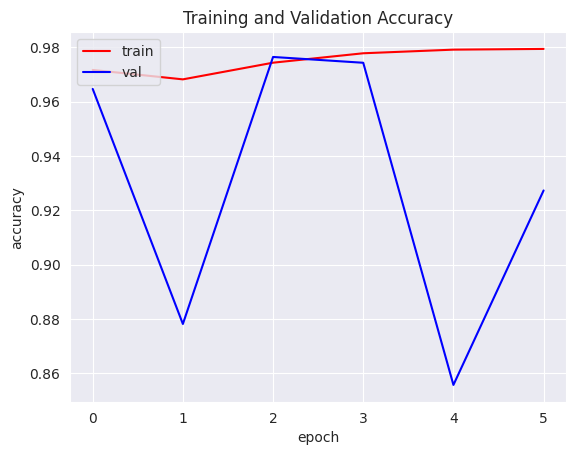

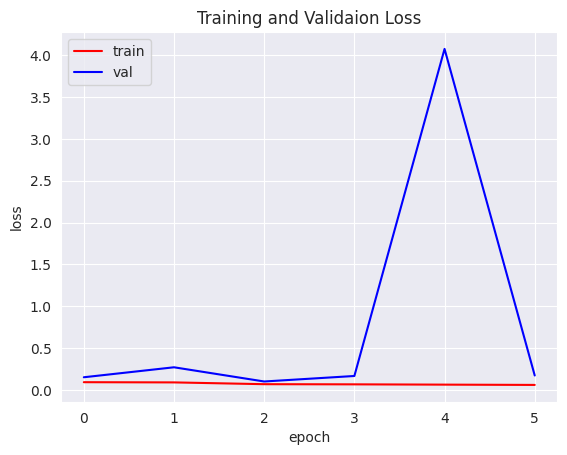

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()




              precision    recall  f1-score   support

      Normal     0.9373    0.9401    0.9387       334
   Pneumonia     0.9761    0.9749    0.9755       838

    accuracy                         0.9650      1172
   macro avg     0.9567    0.9575    0.9571      1172
weighted avg     0.9651    0.9650    0.9650      1172



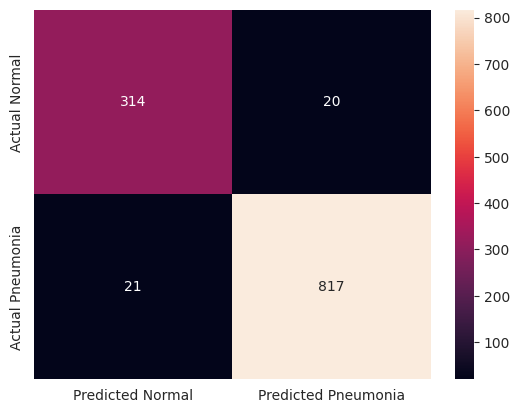

In [ ]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Normal','Pneumonia'], digits=4))